# 【第２回目　課題4】 PyTorchを使った深層学習 (4): ImageNet 学習済モデルの利用．DCNN特徴抽出とファインチューニング．

PyTorchでは，<a href="https://pytorch.org/docs/stable/torchvision/models.html">TORCHVISION MODELS</a> を使うことで，ImageNetの学習済モデルが簡単に利用できます．

### <a href="https://pytorch.org/docs/stable/torchvision/models.html">学習済モデル自動読み込み</a>
torchvision.datasets と同様に，自動ダウンロード機能を備えた torchvision.modelsのモジュール群が用意されています．
* AlexNet
* VGG（定番のVGG．パラメータが512MBもあって巨大なのが難点．)
* ResNet
* SqueezeNet
* DenseNet
* Inception v3
* GoogLeNet
* ShuffleNet v2
* MobileNet v2 (Googleのモバイル用ネットワーク．パラメータが10MB未満．）
* ResNeXt
* Wide ResNet
* MNASNet (最新の自動構築されたモバイル用ネットワーク) <a href="https://arxiv.org/abs/1807.11626">(Mobile Neural Archtecture Search Network)
    
初回実行時には，datasetsと同様に自動的にダウンロードが行われます．（ですので，Proxyが必要な環境では，事前に環境変数を設定する必要があります．)

他にも，object detection, semantic segmentation, video classification のモデルが用意されています．

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display
import time
import os

# proxyの設定．
# keras.datasetsでは，datasetを直接ダウンロードするので，学内マシンからは通常必要．
os.environ["http_proxy"] = "http://proxy.uec.ac.jp:8080/"
os.environ["https_proxy"] = "http://proxy.uec.ac.jp:8080/"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"      # "0":GPU0, "1":GPU1, "0,1":GPUを2つとも使用

import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

## ResNet50 による1000種類分類

まずは，ResNet50 のpretrained modelを使って，1000種類認識をしてみましょう．
以下のコードだけで実行できます．学習済モデルも自動的にダウンロードするので簡単です．
なお，初回実行時は，モデルのダウンロードを行うので，結果が出るまで少し時間が掛かります．

In [2]:
# ResNet50 による 1000種類分類
import torchvision.models as models

In [3]:
resnet50 = models.resnet50(pretrained=True,progress=True)
softmax=nn.Softmax(dim=1)
# pretrained=True とすると，学習済みポラメータも読み込まれる．
# ~/.cache/torch/checkpoints/ の下に読み込まれます．
# ls でダウンロードされていることを確認してみます．
! ls -l ~/.cache/torch/checkpoints/ 

total 1536632
-rw------- 1 yanai YANAI_LAB  32342954 Jul 18  2019 densenet121-a639ec97.pth
-rw------- 1 yanai YANAI_LAB  21383481 Jul 18  2019 efficientnet-b0-08094119.pth
-rw------- 1 yanai YANAI_LAB 108857766 Jul 19  2019 inception_v3_google-1a9a5a14.pth
-rw------- 1 yanai YANAI_LAB 178728960 Dec 26 01:29 resnet101-5d3b4d8f.pth
-rw------- 1 yanai YANAI_LAB 102502400 Dec 25 19:28 resnet50-19c8e357.pth
-rw------- 1 yanai YANAI_LAB 553433881 Jul  1  2019 vgg16-397923af.pth
-rw------- 1 yanai YANAI_LAB 574673361 Jan 10 20:48 vgg19-dcbb9e9d.pth


PyTorchのpre-trained modelは，<a href="https://discuss.pytorch.org/t/whats-the-range-of-the-input-value-desired-to-use-pretrained-resnet152-and-vgg19/1683">ここ</a> にかかれているように，画像は [0, 1] で表現されるように変換したものを，さらに，平均[0.485, 0.456, 0.406], 分散[0.229, 0.224, 0.225] となるように変換して学習されています．
ですので，[0, 255]で読み込んだ画像を
```python
mean=np.array([0.485, 0.456, 0.406], dtype=np.float32)
std=np.array([0.229, 0.224, 0.225], dtype=np.float32)
img=(img/255.0-mean)/std
```
で，変換してから，学習済モデルに渡してやる必要があります．
Pretrained model利用時に，これを行わないと，無意味な認識結果が出力されますので，十分に注意して下さい．

In [4]:
from PIL import Image
img=np.array(Image.open('./lion.jpg').resize((224,224)), dtype=np.float32)
mean=np.array([0.485, 0.456, 0.406], dtype=np.float32)
std=np.array([0.229, 0.224, 0.225], dtype=np.float32)
img=(img/255.0-mean)/std
img=img.transpose(2,0,1)  # HWC -> CHW
img=img[np.newaxis,...]  # adding batch axis
img=torch.from_numpy(img)

resnet50.eval() 
# batch_normalization を eval modelで計算するために，model.eval()で
# eval modeを設定する．(学習時の平均分散を利用．)　
# train modeだと，batch内の平均分散が使われるが，
# この場合 batch_size=1 でbatch内平均分散が計算され，正しくない結果になる．
# batch normalization を使ったモデルで認識する場合は，evel modeへの
# 切り替えは必須なので，注意すること．

with torch.no_grad(): # 勾配計算はしないので，no_grad modeで計算
    out=softmax(resnet50(img)).numpy()[0]
    # numpy()で，Tensor形式から numpy形式に変換
    # batch_size=1 で1枚だけ認識したので，1枚目の結果だけをoutに入れるために[0]がついている

top5   =np.sort(out)[:-6:-1]      # 昇順にソートされるので，最後の5つが top5
top5idx=np.argsort(out)[:-6:-1]   # 

In [5]:
# 認識結果の top-5 の結果の表示
SYNSET_FILE='synset_words.txt'  # ImageNet1000 種類のカテゴリ名が書かれたファイル．
synset=open(SYNSET_FILE).read().split('\n')
for i in range(5):
    print("[%d] %.8f %s" % (i+1,top5[i],synset[top5idx[i]]))

[1] 0.99934548 n02129165 lion, king of beasts, Panthera leo
[2] 0.00010747 n02125311 cougar, puma, catamount, mountain lion, painter, panther, Felis concolor
[3] 0.00007851 n02117135 hyena, hyaena
[4] 0.00007462 n02128385 leopard, Panthera pardus
[5] 0.00006126 n02130308 cheetah, chetah, Acinonyx jubatus


次に TorchVision を使った方法です．こちらの方が簡単です．

TorchVision を使う場合は，以下の様にnormalizeします．
```python
normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
```

In [6]:
# 画像の変換は, TorchVisionを使うと簡単にできます．
import torchvision.transforms as transforms
image_size = (224, 224) 
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
image_transform = transforms.Compose([transforms.Resize(image_size),transforms.ToTensor(),normalize])
img = Image.open('lion.jpg')
img = image_transform(img)
img = img.unsqueeze(0)
resnet50.eval() 
with torch.no_grad(): 
    out=softmax(resnet50(img)).numpy()[0]
top5   =np.sort(out)[:-6:-1]   
top5idx=np.argsort(out)[:-6:-1] 
for i in range(5):
    print("[%d] %.8f %s" % (i+1,top5[i],synset[top5idx[i]]))

[1] 0.99930012 n02129165 lion, king of beasts, Panthera leo
[2] 0.00013924 n02125311 cougar, puma, catamount, mountain lion, painter, panther, Felis concolor
[3] 0.00006286 n02117135 hyena, hyaena
[4] 0.00005809 n02422106 hartebeest
[5] 0.00005807 n02130308 cheetah, chetah, Acinonyx jubatus


ResNet50 のネットワークを表示してみます．各res blockにskip connectionが入っていること(addのconnected to をたどってみましょう．)と，ネットワークの最後にGlobalAveragePooling (出力のfeature mapが 1x1 になっています), Flatten, Denseが入っていることを確認しましょう．

In [7]:
# ResNet50 の表示
print(resnet50)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## VGG16 を使った特徴抽出

VGG16 の fc2 から 4096次元特徴ベクトルを抽出してみましょう．
初回実行時は，モデルのダウンロードを行うので，結果が出るまで少し時間が掛かります．

4096次元ベクトルは，類似画像検索や，SVMを用いた画像分類の特徴量として利用できます．なお，画像分類は後述するfine-tuningでも可能で，一般にはそちらの方が高精度ですが，学習にはGPUが必要で時間が掛かるので，CPUのみで実行可能なSVMを使った画像分類の学習も場合によっては有用です．

なお，データセットは，<a href="http://mm.cs.uec.ac.jp/animal.zip">動物10種各100枚</a>を使ってください．
Jupyter の terminal を開いて，Jupyterの作業ディレクトリに展開してください．
```
setenv http_proxy http://proxy.uec.ac.jp:8080/
wget http://mm.cs.uec.ac.jp/animal.zip
unzip animal.zip
```
としてください．(実行セルで， !(linux コマンド) としても実行できます．)

なお，IEDの場合は /usr/local/class/object/animal, CEDの場合は/ced-home/staff/yanai/media/animal に同じデータセットがありますので，フルパス名を指定すれば，ダウンロード不要です．

In [8]:
vgg16 = models.vgg16(pretrained=True,progress=True)
softmax=nn.Softmax(dim=1)
# pretrained=True とすると，学習済みポラメータも読み込まれる．
# ~/.cache/torch/checkpoints/ に読み込まれます．VGG16は550MBもあるので，不要になったら消去しましょう．
# ls でダウンロードされていることを確認してみます．
! ls -l ~/.cache/torch/checkpoints/ 

total 1536632
-rw------- 1 yanai YANAI_LAB  32342954 Jul 18  2019 densenet121-a639ec97.pth
-rw------- 1 yanai YANAI_LAB  21383481 Jul 18  2019 efficientnet-b0-08094119.pth
-rw------- 1 yanai YANAI_LAB 108857766 Jul 19  2019 inception_v3_google-1a9a5a14.pth
-rw------- 1 yanai YANAI_LAB 178728960 Dec 26 01:29 resnet101-5d3b4d8f.pth
-rw------- 1 yanai YANAI_LAB 102502400 Dec 25 19:28 resnet50-19c8e357.pth
-rw------- 1 yanai YANAI_LAB 553433881 Jul  1  2019 vgg16-397923af.pth
-rw------- 1 yanai YANAI_LAB 574673361 Jan 10 20:48 vgg19-dcbb9e9d.pth


In [9]:
# 念のため，認識してみます．
# 2位以下はResNetと若干異なっていますが，1位はあっているはずです．
image_size = (224, 224) 
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
image_transform = transforms.Compose([transforms.Resize(image_size),transforms.ToTensor(),normalize])
img = Image.open('lion.jpg')
img = image_transform(img)
img = img.unsqueeze(0)
vgg16.eval() 
with torch.no_grad():
    out=softmax(vgg16(img)).numpy()[0]
top5   =np.sort(out)[:-6:-1]   
top5idx=np.argsort(out)[:-6:-1] 
for i in range(5):
    print("[%d] %.8f %s" % (i+1,top5[i],synset[top5idx[i]]))

[1] 0.99754685 n02129165 lion, king of beasts, Panthera leo
[2] 0.00033962 n02112137 chow, chow chow
[3] 0.00028383 n02115913 dhole, Cuon alpinus
[4] 0.00026045 n02106030 collie
[5] 0.00013270 n02410509 bison


In [10]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
    
vgg16fc7 = torch.nn.Sequential(
    vgg16.features,
    vgg16.avgpool,
    Flatten(),
    *list(vgg16.classifier.children())[:-3]  # 最後の3つのlayer(relu,dropout,fc1000)を削除
)
# 表示してみます．fc7 (fc4096)が最終出力になっているはずです．
print(vgg16fc7)

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [11]:
vgg16fc7.eval()
with torch.no_grad():
    fc7=vgg16fc7(img)
print(fc7.shape)     # shapeの表示
print(fc7[0][0:100]) # fc7特徴量を最初の100次元分だけ表示してみます．

torch.Size([1, 4096])
tensor([-0.4662, -2.8360, -3.2846,  0.6673, -1.7138, -4.5680,  1.4430, -1.3399,
        -1.5306,  1.4850, -1.2114,  0.0782,  0.2708, -0.5227, -2.2403, -1.6590,
        -1.8959, -1.2780, -1.6734, -0.1346, -3.0772, -2.9543, -2.2964,  0.0534,
        -0.7952,  4.3078, -2.4280,  1.2097, -0.9758,  1.4676, -0.4221, -0.6301,
        -1.3490, -0.1666, -2.0901, -1.1264, -1.8081, -2.0467, -2.2239, -3.1684,
         0.2978, -1.4273,  0.6979, -2.1675, -1.2621,  0.3755,  4.6138,  0.1551,
        -1.8192, -4.0548, -3.1900,  0.8393, -3.8521, -1.2662,  1.3195, -3.0540,
        -0.9008, -2.7653, -0.1400, -2.2235, -1.8330, -0.7277,  1.0339, -1.2487,
        -1.7718, -1.4427, -1.8328, -1.7777, -2.6309, -1.0341, -3.1651, -1.8286,
         0.6546, -2.0965, -2.3978,  0.9357, -1.8812, -2.3502, -0.4309, -1.3155,
        -2.1128, -2.8751, -3.5441, -1.5315, -2.1354,  0.0543, -3.0295, -2.0644,
        -0.2059, -0.8311, -2.8010,  0.2827,  0.5275, -2.9884, -0.3949, -0.4119,
        -0.6293, -

次に学習画像の読み込みです．DataLoaderを使う方法もありますが，ここでは一気に2クラス分の200枚読み込んで，まとめてfc7特徴を抽出してしまいましょう．

In [12]:
import glob
# imglist に cat100枚，dog100枚の合計200枚分のファイル名を用意します．
# cat dog elephant fish horse lion penguin tiger whale wildcat があります．
imglist=glob.glob('animal/lion/*.jpg')+glob.glob('animal/tiger/*.jpg')

# 200枚画像をimgsに読み込みます．
in_size=224
imgs = np.empty((0,in_size,in_size,3), dtype=np.float32)

for i,img_path in enumerate(imglist):
    if i%100==0:
        print("reading {}th image".format(i))
    x = np.array(Image.open(img_path).resize((in_size,in_size)), dtype=np.float32)
    x = np.expand_dims(x, axis=0)
    imgs = np.vstack((imgs,x))
    
mean=np.array([0.485, 0.456, 0.406], dtype=np.float32)
std=np.array([0.229, 0.224, 0.225], dtype=np.float32)
imgs=(imgs/255.0-mean)/std
imgs=imgs.transpose(0,3,1,2)  # HWC -> CHW
img=torch.from_numpy(imgs)
print(imgs.shape)

reading 0th image
reading 100th image
(200, 3, 224, 224)


In [13]:
# 200枚処理するので，GPUを使います．
device = 'cuda' if torch.cuda.is_available() else 'cpu'
vgg16fc7 = vgg16fc7.to(device)

vgg16fc7.eval()
with torch.no_grad():
    fc=vgg16fc7(img.to(device)).cpu().numpy()
    # gpuで処理した結果を cpuに戻して，numpy形式にします．
print(fc.shape)     # shapeの表示

(200, 4096)


以下では，抽出したfc特徴を，5-fold cross validationで学習・評価します．

In [14]:
from sklearn.svm import LinearSVC
 
# 分類器のオブジェクトを生成．
# Cはソフトマージンのハイパーパラメータです．
model_svm = LinearSVC(C=1.0)
num = len(fc)
label=np.append(np.ones(num//2,dtype=np.float32),(-1)*np.ones(num//2,dtype=np.float32))
acc=[]

# 5 cross validation で分類精度評価
for f in range(5):
    # indexの作成．5で割ってf余る数がtestのindex, そうでない数がtrainのindex.
    train=[n for n in range(num) if n%5!=f]
    test =[n for n in range(num) if n%5==f]

# トレーニングデータで学習する
# label は 0,1のベクトルになります．
    model_svm.fit(fc[train], label[train])
 
# テストデータの分類をする
#label_predict = model.predict(fc[test])  #0/1分類
#predict_score = model.decision_function(fc[test]) #超平面からの符号つき距離
    acc.append(model_svm.score(fc[test],label[test])) # 分類＋accuracyの計算
    
    # print('accuracy={:.5%}'.format(model_svm.score(fc[test],label[test])))
print('accuracy={:.5%}'.format(np.average(acc)))

accuracy=100.00000%


## VGG16 のファインチューニングによる小規模データセットの学習

VGG16の学習済畳み込み層を使って，小規模画像データセットの学習を行ってみましょう．

データセットは同じく動物データを使いますが，ここでは10クラスのマルチクラス分類を行います．

今度は，ImageLoaderを使ってみましょう．

クラスごとにサブディレクトリが別れている場合は，<a href="https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder">torchvision.datasets.ImageFolder</a>を使って，簡単に dataset objectを生成できます．ラベルデータも同時に作成してくれるので，手間が省けます．

次に，<a href="https://pytorch.org/docs/stable/data.html#torch.utils.data.Subset">torch.utils.data.Subset</a>を使って，train/testにdatasetを分割します．

あとは，MNISTの時と同じで，train/testの<a href="https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader">DataLoader</a>を生成します．

In [15]:
# まず，image_transform を定義します．ImageFolderで指定するので，先に
# 定義しておく必要があります．

# リサイズ，CHW変換，正規化 の標準的な image_transform
image_size = (224, 224) 
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
image_transform = transforms.Compose([transforms.Resize(image_size),transforms.ToTensor(),normalize])

# リサイズ，CHW変換，正規化 に加えて，+-20度のランダム回転，
# 0.8-1.2倍のランダム縦横比変換＋0.7-1.0倍のランダムクロップ，ランダム左右反転，のデータ拡張ありの image_transform
image_transform_aug = transforms.Compose([transforms.RandomRotation(20),
                                          transforms.RandomResizedCrop(image_size, scale=(0.7, 1.0), ratio=(0.8, 1.2)),
                                          transforms.RandomHorizontalFlip(), transforms.ToTensor(), normalize
                                        ])

# ImageFolfer では，クラス毎にディレクトリがあって，そのクラスの画像が入っていることを想定しています．
# animal/lion/*.jpg, animal/dog/*.jpg, animal/cat/*.jpg  ....のような感じです．
#   animal datasetは，まさにそのようになっています．
dataset=torchvision.datasets.ImageFolder(root="./animal", transform=image_transform) 

# データ拡張ありの場合は，以下のを用いる． image_transform -> image_transform_aug
augmentation=False # データ拡張しない場合は False，拡張する場合は True にする．

if augmentation:
    # データ拡張あり (学習データのみ)
    dataset2=torchvision.datasets.ImageFolder(root="./animal", transform=image_transform_aug) 
else:
    # データ拡張なし
    dataset2=dataset
    
num = len(dataset) # animal datasetの場合，1000

# indexの作成．5で割り切れない数がtestのindex, 5の倍数がtrainのindex.
# つまり，train:text=4:1=80%:20% とする．
train_idx=[n for n in range(num) if n%5!=0]
test_idx =[n for n in range(num) if n%5==0]

trainset  = torch.utils.data.dataset.Subset(dataset2, train_idx)
testset   = torch.utils.data.dataset.Subset(dataset, test_idx)

batch_size=64

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=10)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=10)

次は，モデル定義です．

VGG16を畳み込み層だけ読み込んだモデルvgg16と，その出力を新しく追加しする全結合2層のtop_modelを用意します．
さらに，その2つのモデルをModel によって結合します．vgg16の出力をtop_modelの入力として，それを出力とする，vgg_modelを
定義します．

結果的に，元々のVGG16の全結合層だけを新しく入れ替えて，再学習することになります．vgg_modelの元々の部分は学習済のパラメータが設定されていて，一方，新しい部分はランダム値で初期化されます．

このvgg_modelを学習します．ただし，vgg_modelの前半のレイヤーは taininable = False として，学習しないようにします．
パラメータの更新が，追加した全結合と，vggの最後の畳み込み層のみになるので，学習時間が大幅に節約できます．

このように fine-tuningでは，出力に近い層だけを学習するのが一般的です．


In [16]:
# vgg16 のconvの学習済パラメータはfinetuneしないように凍結します．
for param in vgg16.features.parameters():
    param.requires_grad = False

# finetune用の model の定義．最後のlayerをcutして，nn.Linear(4096,10) を追加
model = torch.nn.Sequential(
    vgg16.features,
    vgg16.avgpool,
    Flatten(),
    *list(vgg16.classifier.children())[:-1],  # 最後のlayer(fc1000)を削除
    nn.Linear(4096,10)
)
# 表示してみます．10class分のfc出力が最終出力になっているはずです．
print(model)

# GPUに転送します．
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

課題3と同様に，学習中の経過のグラフ表示用にcallback用のShowGraphクラスを用意します．（ここは中身の理解不要．）

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display
import time
# callback のクラス ShowGraphを定義
class ShowGraph:
    def __init__(self,max_epoch):
        # 表示エリアの設定
        self.fig=plt.figure(figsize=(8,4))
        self.fig1 = self.fig.add_subplot(121)
        self.fig1.axis([0, max_epoch, 0.5, 1.0])
        self.fig1.set_title('accuracy')
        self.fig1.set_ylabel('accuracy')
        self.fig1.set_xlabel('epoch')
        self.fig2 = self.fig.add_subplot(122)
        self.fig2.axis([0, max_epoch, 0, 5])
        self.fig2.set_title('loss')
        self.fig2.set_ylabel('loss')
        self.fig2.set_xlabel('epoch')
        self.max_epoch=max_epoch
        self.start=time.time()
    
    # 学習の最初に呼び出される
    def on_train_begin(self, logs={}):
        self.losses=[]
        self.losses_val=[]
        self.acc=[]
        self.acc_val=[]
        self.n_epoch=[]
        self.n_epoch_v=[]
    
    # 各epochの最後に呼び出される
    def on_epoch_end(self, epoch, loss, acc, vloss, vacc):
        self.n_epoch.append(epoch)
        self.n_epoch_v.append(epoch)
        self.acc.append(acc)
        self.acc_val.append(vacc)     
        self.losses.append(loss)
        self.losses_val.append(vloss)    
        self.test_acc=vacc
    
        display.clear_output(wait = True)
        self.fig1.plot(self.n_epoch,self.acc,"b")
        self.fig1.plot(self.n_epoch_v,self.acc_val,"r")
        self.fig1.legend(['train', 'test'], loc='upper left')
        self.fig2.plot(self.n_epoch,self.losses,"b")
        self.fig2.plot(self.n_epoch_v,self.losses_val,"r")
        self.fig2.legend(['train', 'test'], loc='upper right')
        display.display(self.fig)
        
    def on_epoch_train(self, epoch, loss, acc): # validationを評価しないepochの表示用
        self.n_epoch.append(epoch)
        self.acc.append(acc)
        self.losses.append(loss)
    
        display.clear_output(wait = True)
        self.fig1.plot(self.n_epoch,self.acc,"b")
#        self.fig1.legend(['train', 'test'], loc='upper left')
        self.fig2.plot(self.n_epoch,self.losses,"b")
#        self.fig2.legend(['train', 'test'], loc='upper right')
        display.display(self.fig)
              
    # デストラクタ(オブジェクトが消滅時に実行される)  
    # グラフが２つ表示されるのを防止．さらに最終val acc値の表示．
    def __del__(self):
        display.clear_output(wait = True)
        print("val_acc: ",self.test_acc) 
        print('Time: ',time.time()-self.start)

学習を行う．課題3の MNIST とほぼ一緒．

val_acc:  0.98
Time:  103.57957172393799


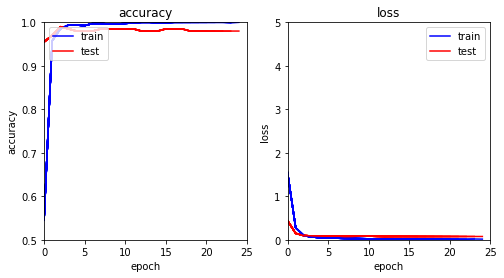

In [18]:
num_epoch=25
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1, min_lr=0.00001)
#optimizer = optim.Adam(model.parameters())
show_graph=ShowGraph(num_epoch)
show_graph.on_train_begin();

def train():
    loss=0
    total=0
    total0=0
    correct=0
    model.train()
    for i, (inputs, labels) in enumerate(trainloader, 0):
        outputs = model(inputs.to(device))
        labels=labels.to(device)
        loss0= loss_fn(outputs, labels)
        loss+= loss0.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        total0+=1
        correct += (predicted == labels).sum().item()
        optimizer.zero_grad()
        loss0.backward()
        optimizer.step()
    loss=loss/total0
    acc=correct/total 
    return loss, acc

def validate():
    model.eval()
    with torch.no_grad():
         vloss=0
         total2=0
         total20=0
         correct2=0
         for (inputs, labels) in testloader:
             outputs = model(inputs.to(device))
             labels=labels.to(device)
             vloss += loss_fn(outputs, labels).item()
             _, predicted = torch.max(outputs.data, 1)
             total2 += labels.size(0)
             total20+=1
             correct2 += (predicted == labels).sum().item()
         vloss=vloss/total20
         vacc=correct2/total2
    return vloss, vacc   

for epoch in range(num_epoch):
    l, a = train()   
    lv, av = validate()
    scheduler.step(lv) # val_lossが下がらなければlrを下げる
    show_graph.on_epoch_end(epoch,l,a,lv,av)
            
del show_graph

### 課題4

以下の小問の(1)-(2)を解答すること．(3)は任意（できるだけやってみる方が望ましい．）．

1. ResNet50, DenseNet, MobileNetV2で，3枚以上の画像について，それぞれ1000種類認識を行うこと．
1. 上記のデータセットで，VGG16をfine-tuningして，画像分類を行うこと．データ拡張しない場合と，する場合を比較せよ．
1. (2)と同様に, ResNet50, DenseNet など，別のネットワークで fine-tuningして，学習時間と精度を比較せよ．

(2), (3)は以下のデータセットのどれかを利用すること．UEC-Food20 のみ20種類で，あとは10種類です．すべて1クラス100枚ずつ入っています．  
（自分で用意可能な人は，自分で用意したものを利用してもよい．各カテゴリ100枚10クラス以上用意せよ．）

 * UEC-Food20 http://mm.cs.uec.ac.jp/uecfood20.zip
 * UEC-Food10 http://mm.cs.uec.ac.jp/uecfood10.zip (上記の10種類版．メモリが足りない場合にどうぞ．)
 * FlickrMaterialDatabase(FMD) http://mm.cs.uec.ac.jp/material10.zip
